# Introduction

This demo illustrates how a third-party researcher could inspect an LLM's training data for a particular bio-risk concern; i.e. that the model wasn't given training data that is dangerous. 

This is composed of two notebooks, `AI_Owner` and `Researcher`, wearing the two hats of the personas involved:
- The represenative of the AI Lab that manages the private data and the AI Lab's infrastructure for private access
- A third-party evaluator who would like to do AI Safety research

We will jump between the two as we illustrate the flow.

## What is the external access problem?
Meaningful research on AI systems sometimes require access to proprietary AI models and datasets. Conventional approaches to giving external access typically are:
   - *Open Access*: requires revealing the data
   - *Onsite Access*: storing the assets in a secured facility, and have researchers travel to conduct their study in-person, which is limited to the time spent on-site and expensive
   - *API Access*: restricted to pre-defined APIs and difficult to expand due to the risk of data/assets being extracted

Third-party access for researchers to study proprietary LLMs are typically denied due to **competitive, trust & safety, security, privacy, and legal concerns**, resulting in limited means to address, or even identify, AI safety issues. As a result, answering questions like the one below is difficult.

#### Does the model's knowledge include the creation of pathogens and deadly chemicals?

PySyft proposes a paradigm where a third-party researchers can answer approved questions, whilst the private assets never leave the premises of the AI Lab. To ensure security, we will be using an air-gapped deployment composed of two servers:
- Low-side: can be accessed by the researchers. However, it does not store any private assets, but fake counterparts that "mimic" the private assets.
- High-side: a server inside the internal AI Lab's network that contains the private assets. The private assets cannot be accessed by any outside parties.

A representative of the AI Lab is responsible for reviewing, approving and forwarding computational results back from high side to low side.

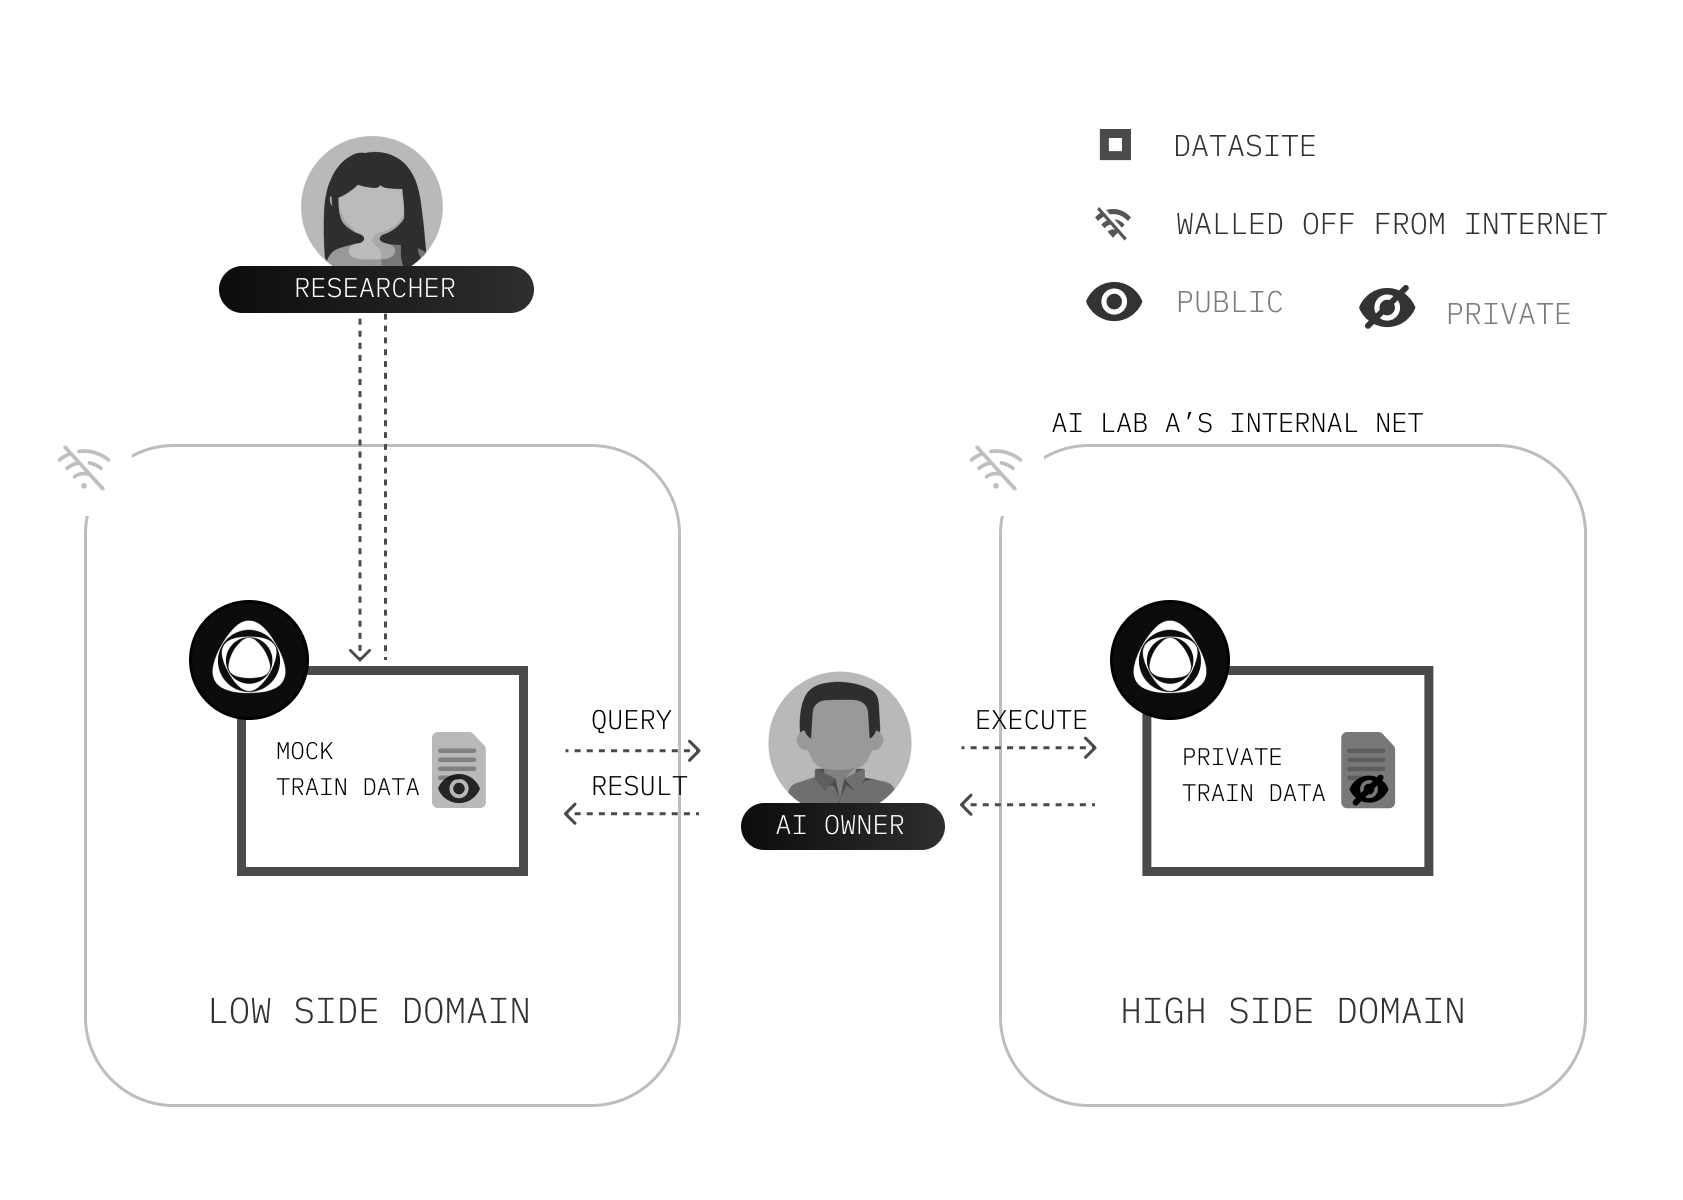

<br>
<hr>

## Steps

We are investigating the presence of dangerous biological agents in fine-tuning datasets. This would entail:
- AI Owner uploads instruction data to the high-side, and mock data to the low-side
- Given a list of dangerous biological agents, the researcer:
    - writes an eval to identify the data points that contain the agents, using a form of search (e.g. TF-IDF, semantic search, basic keyword search)
    - submits the eval to the AI owner for review
- AI Owner reviews and approves the code, sending the result back

Let's begin by pretending we're the model owner. The first thing you need to do is to launch the datasite with the two servers, one to host the mock and one to host the private data. Documentation on how to do this is available [here](https://docs.openmined.org/en/latest/deployment/deployment-doc-1-2-intro-req.html).

Once that's done, you will need to use syft to setup and give access to the researcher. Let's install it as:

In [ ]:
!pip install syft==0.9.1

If you get any installation errors, create a github issue [here](https://github.com/OpenMined/PySyft/issues/new?assignees=&labels=Type%3A+Bug+%3Abug%3A&projects=&template=bug.md&title=) and — if you want especially fast service — join [slack.openmined.org](https://communityinviter.com/apps/openmined/openmined/) and share your Github Issue in the #support channel.

# AI Owner
<hr>


## 1. Preparing and uploading the data assets

The data is not available, but we can create a fake private dataset to experiment with.

In [ ]:
import uuid
import random
import pandas as pd 

num_records = 10
sources = ["dataset A", "dataset B", "dataset C", "dataset D"]
texts_with_subtilis = [
    "Bacillus subtilis is commonly used in industrial processes for enzyme production.",
    "The genetic structure of Bacillus subtilis enables it to withstand various environmental stresses.",
]

texts_without_subtilis = [
    "This bacterium is crucial for fermentation processes in food production.",
    "Many industrial enzymes are derived from bacterial species due to their high efficiency.",
    "The genetic makeup of this microorganism aids in its adaptation to diverse environments.",
    "Certain bacterial strains are essential in soil health due to their nitrogen-fixing abilities.",
    "Bacteria play a vital role in nutrient recycling and organic matter decomposition.",
    "This microorganism is often used in the pharmaceutical industry for antibiotic production.",
    "Its unique structure makes it resilient in various industrial applications.",
    "Some bacterial strains produce antibiotics effective against harmful microbes.",
    "This microorganism is used extensively in biotechnology applications for enzyme production.",
]

def generate_private_data(num_records):
    texts = texts_with_subtilis + texts_without_subtilis

    random.shuffle(texts)
    data = {
        "id": [uuid.uuid4().hex for _ in range(num_records)],
        "text": [random.choice(texts) for _ in range(num_records)],
        "source": [random.choice(sources) for _ in range(num_records)],
    }
    
    df = pd.DataFrame(data).drop_duplicates(subset='text').reset_index(drop=True)
    return df

df = generate_private_data(num_records)
df.head()

### Uploading the data to the datasite servers

While PySyft can work in any Python 3.10+ runtime, it has special support for Jupyter based notebooks, thus recommended to use it within a Jupyter Lab or Notebook. 

Once that's set, we can start with the private data by importing syft.

In [ ]:
import syft as sy
sy.requires("==0.9.1")

#### A. High side

By running the below cell, you'd successfully log in as the administrator of the server priorly launched. Here are the default credentials, but if you are using k8s, you might need to get the auto-generated password.

In [ ]:
high_side_client = sy.login(url="<HIGH_SIDE_IP>", email="info@openmined.org", password="changethis")
high_side_client

With the server successfully deployed and accesible, now it's time for you to load in the assets you want to allow a third-party evaluator to audit. Here it is the generated dataframe that mimics the training data of an AI lab.

In [ ]:
dataset_to_upload = sy.Dataset(
    name="AI Lab Training Dataset",
    description="Training dataset for LLMs.",
    asset_list=[
        sy.Asset(
            name="A dataset mix of public and private datasets", 
            data=df,
            mock=sy.ActionObject.empty()
        )
    ]
)

We can check the object before uploading it:

In [ ]:
dataset_to_upload

In [ ]:
high_side_client.upload_dataset(dataset_to_upload)

In [ ]:
high_side_client.datasets

Seems it worked. We can now proceed similarly for the low-side server, that exclusively hosts mock data since it is exposed to researchers and to  the internet possibly.

#### B. Low-side: mock data only

The mock data is identical to the real dataset in every way (size, type, columns, etc.) except that it's values are made up. This will be useful for the third-party auditor to prepare their project — so that they write code which they know will actually run on the private data.

We need to create the mock dataset first:

In [ ]:
df_copy = pd.DataFrame().reindex_like(df)

In [ ]:
df_copy['id'] = 9999
df_copy['text'] = 'Here lies a text from a dataset for training an LLM' 
df_copy['source'] = 'OpenSource Dataset XYZ'

In [ ]:
df_copy.head()

Now, we start the process by connecting to the low-side server:

In [ ]:
low_side_client = sy.login(url="<LOW_SIDE_IP", email="info@openmined.org", password="changethis")
low_side_client

We create a "contributor" which is the name and contact email of the person who uploaded the dataset. That way if a third-party auditor has questions about the dataset, they know who to ask. Then, we create a `syft.Dataset`` object and upload only the mock data.

In [ ]:
main_contributor = sy.Contributor(name="Jeffrey Salazar", role="Uploader", email="jsala@ailab.com")

dataset_to_upload = sy.Dataset(
    name="AI Lab Training Dataset",
    description="Training dataset for LLMs.",
    asset_list=[
        sy.Asset(
            name="A dataset mix of public and private datasets", 
            data=df_copy,
            mock=df_copy,
            contributors=[main_contributor],
        )
    ]
)

In [ ]:
low_side_client.upload_dataset(dataset_to_upload)

In [ ]:
low_side_client.datasets

### Generate credentials for the researcher

Now that the dataset is loaded into the datasite, the AI Model Owner is ready for third-party auditors to gain access and submit projects for approval. Assuming John Doe below was vetted to take part of this research program, the AI Owner generates a set of credentials for them:


In [ ]:
low_side_client.register(
    name="John Doe", 
    email="johndoe@gmail.com", 
    password="feynman24",
    password_verify="feynman24",
)

<hr>

## Waiting for incoming research proposals


- At this point the servers are live and the lowside is discoverable and accesible by the researchers, who can view the mock objects and request to execute their code on your private dataset.
- No one can see the AI Owner's private dataset, and no private information has left their premises.


We move now to the Researcher's notebook to submit an evaluation against this data.
<hr>

## 3. Review incoming projects

With the code request submitted to the AI Owner, now it's the AI owner's turn to review the project and decide whether they want to allow the evaluator's code to be run.


In [ ]:
low_side_client.requests

We can inspect in detail the policies of the code and the exact proposed execution:

In [ ]:
func = low_side_client.requests[0].code
func

<hr>

## 4. Execute submitted code on the private assets

As we saw, the data does not live on the low side server, thus the code must be moved to the high side one and the execution needs to be manually triggered by the AI Owner and the result must be shared afterwards.

In [ ]:
private_asset_ptr = high_side_client.datasets[0].assets[0]
private_asset_ptr

In [ ]:
private_data = private_asset_ptr.data
private_data.head()

In [ ]:
result = func.unsafe_function(dataset=private_data)

The AI Owner can inspect the result before it's shared back:

In [ ]:
for r in result:
    print(r)
    print(result[r])
    print("\n")

<hr>

## 5. Submit the results back to the researcher


In [ ]:
low_side_client.requests[0].accept_by_depositing_result(result)

While this only does one round of back-and-forth interaction between an third-party evaluator and an AI model owner, conventionally there would be some discussion between these parties during the course of the project. For example, a model owner might reach out over slack or email to discuss their submission, recommend refinements, and discuss properties about the private assets that might be relevant to the project.

<hr>

# Summary

As an AI Owner, you managed to facilitate a third-party evaluator's analysis against your proprietary data without them ever seeing it and without results leaving your hardware without your explicit approval and action, being able to review every line of code that was run. For questions, reach out on our support channels!
